epoch 1, train_loss 0.0001, test_loss 0.0000
epoch 2, train_loss 0.0000, test_loss 0.0000
epoch 3, train_loss 0.0000, test_loss 0.0000
epoch 4, train_loss 0.0000, test_loss 0.0000
epoch 5, train_loss 0.0000, test_loss 0.0000
epoch 6, train_loss 0.0000, test_loss 0.0000
epoch 7, train_loss 0.0000, test_loss 0.0000
epoch 8, train_loss 0.0000, test_loss 0.0000
epoch 9, train_loss 0.0000, test_loss 0.0000
epoch 10, train_loss 0.0000, test_loss 0.0000


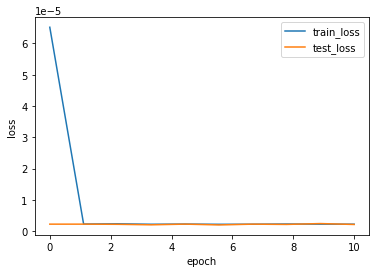

In [1]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.utils.data as Data

# 获取数据集
batch_size = 100
feature_size = 500
def synthetic_data(w, b, num_examples):  #@save
    """生成 y = Xw + b + 噪声。"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.ones(feature_size)
true_w = true_w * 0.0056
true_b = 0.028
x_train, y_train = synthetic_data(true_w, true_b, 7000)
x_test, y_test = synthetic_data(true_w, true_b, 3000)

# 做一个迭代器，分批吐数据
# 把数据放在数据库中
torch_dataset_train = Data.TensorDataset(x_train, y_train)
torch_dataset_test = Data.TensorDataset(x_test, y_test)

# 分批次吐数据
train_iter = Data.DataLoader(
    # 从数据库中每次抽出batch size个样本
    dataset=torch_dataset_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
)

test_iter = Data.DataLoader(
    # 从数据库中每次抽出batch size个样本
    dataset=torch_dataset_test,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
)


# 定义模型参数
num_inputs, num_outputs = 500, 1

W1 = torch.tensor(np.random.normal(0, 0.01, (num_outputs, num_inputs)), dtype=torch.float)
b1 = torch.zeros(num_outputs, dtype=torch.float)

params = [W1, b1]
for param in params:
    param.requires_grad_(requires_grad=True)


# 定义模型
def net(X):
    X = X.view((-1, num_inputs))
    return torch.matmul(X, W1.t()) + b1

# 定义损失函数
loss = torch.nn.MSELoss()

# 定义优化函数
def SGD(params, lr):
    for param in params:
        param.data -= lr * param.grad
        
# 计算模型在数据集上的准确率
# 计算模型在数据集上的准确率
def evaluate_accuracy(data_iter, net, loss):
    acc_sum, n = 0.0, 0
    test_l_sum = 0.0
    for X, y in data_iter:
#         acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
        l = loss(net(X), y).sum()
        test_l_sum += l.item()
        n += y.shape[0]
    return acc_sum / n, test_l_sum / n

# 定义模型训练参数
def train(net, train_iter, test_iter, loss, num_epochs, batch_size, params=None, lr=None, optimizer=None):
    train_loss = []
    test_loss = []
    for epoch in range(num_epochs):
        train_acc_sum, train_l_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum()
            
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            l.backward()
            if optimizer is None:
                SGD(params, lr)
            else:
                optimizer.step()
                
            train_l_sum += l.item()
#             print('y_hat.shape', y_hat.shape)
#             print('y.shape', y.shape)
#             train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
        test_acc, test_l = evaluate_accuracy(test_iter, net, loss)
        train_loss.append(train_l_sum/n)
        test_loss.append(test_l)
       
        print('epoch %d, train_loss %.4f, test_loss %.4f' % (epoch + 1, train_l_sum / n, test_l))
    return train_loss, test_loss
            
num_epochs = 10
lr = 0.1

train_loss, test_loss = train(net, train_iter, test_iter, loss, num_epochs, batch_size, params, lr)

#画图
x = np.linspace(0, len(train_loss), len(train_loss))
plt.plot(x, train_loss, label = 'train_loss', linewidth=1.5)
plt.plot(x, test_loss, label='test_loss', linewidth = 1.5)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()